In [1]:
%load_ext autoreload
%autoreload 2

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import tensorflow as tf

from sklearn import manifold, decomposition, neighbors

from state_of_the_artefact.systems import Recommender, Agent
from state_of_the_artefact.utilities import one_hot, reverse_sequences

sns.set()
spacer = '          '

## LOAD DATA & SETUP GLOBAL VARIABLES

In [48]:
data_path = os.path.join("..", "data", "output")

data_uniform = pd.read_pickle(os.path.join(data_path, "sim_a8_e250_uniform_origin_2020-08-09T16-52-52.gz"))
data_frecency = pd.read_pickle(os.path.join(data_path, "sim_a8_e250_density_origin_2020-08-08T20-09-03.gz"))
data_density = pd.read_pickle(os.path.join(data_path, "sim_a8_e250_frecency_origin_2020-08-09T11-28-41.gz"))

simulations = [data_uniform, data_frecency, data_density]
settings = [pd.concat([data["parameters"], data["timings"]]) for data in simulations]
sim_labels = ["Uniform", "Density", "Frecency"]
agent_labels = [f"agent_{i}" for i in range(settings[0].n_agents)]

UP_TO_EPOCH = 50

print("\n".join([a + spacer + b + spacer + c for a, b, c in zip(*[s.to_string().split("\n") for s in settings])]))

n_epochs                              250          n_epochs                              250          n_epochs                              250
n_agents                                8          n_agents                                8          n_agents                                8
n_neighbours                            1          n_neighbours                            1          n_neighbours                            1
n_artefacts                            10          n_artefacts                            10          n_artefacts                            10
sample_mode                        origin          sample_mode                        origin          sample_mode                        origin
novelty_preference                   0.75          novelty_preference                   0.25          novelty_preference                   0.25
budget                                100          budget                                100          budget                            

## EVALUATIONS

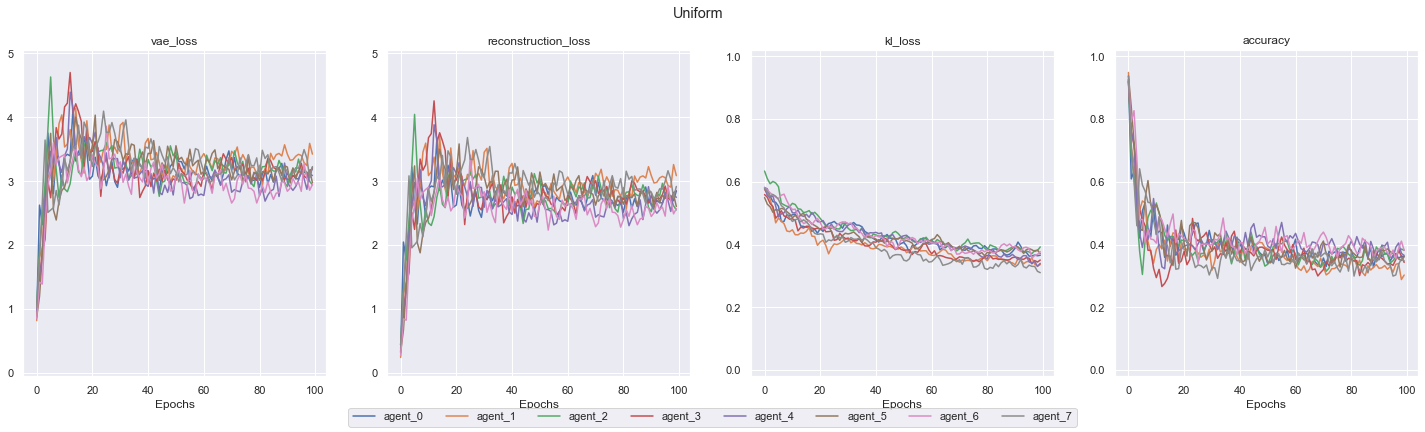

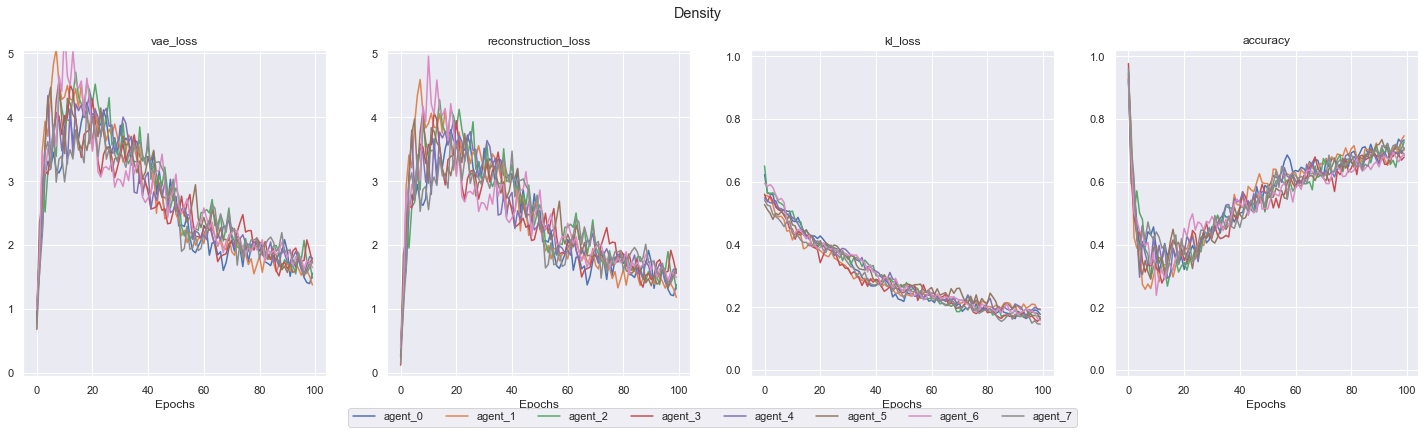

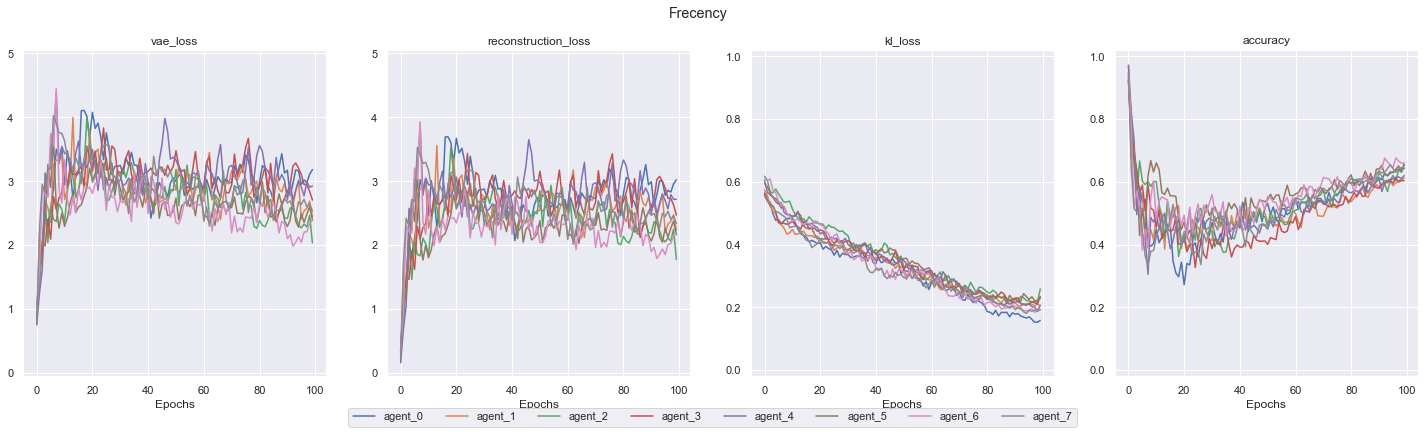

In [65]:
keys = ["vae_loss", "reconstruction_loss", "kl_loss", "accuracy"]
ylims = [(-.05, 5.05), (-.05, 5.05), (-0.02, 1.02), (-.02, 1.02)]

evals = [(data["evaluations"], data['parameters']) for data in simulations]

for l, (evaluation, parameters) in enumerate(evals):
    n_agents = parameters.n_agents

    fig, ax = plt.subplots(1, 4, figsize=(25, 6), )
    fig.suptitle(sim_labels[l])
    
    for i, key in enumerate(keys):
        for j in range(n_agents):
            evaluation[key][j::n_agents][:100].plot(label=agent_labels[j], ax=ax[i], use_index=False, ylim=ylims[i])
            ax[i].set_title(key)
            ax[i].set_xlabel("Epochs")
    
    fig.legend(loc="lower center", labels=agent_labels, ncol=n_agents)
    plt.show()

## INTERACTION MATRICES

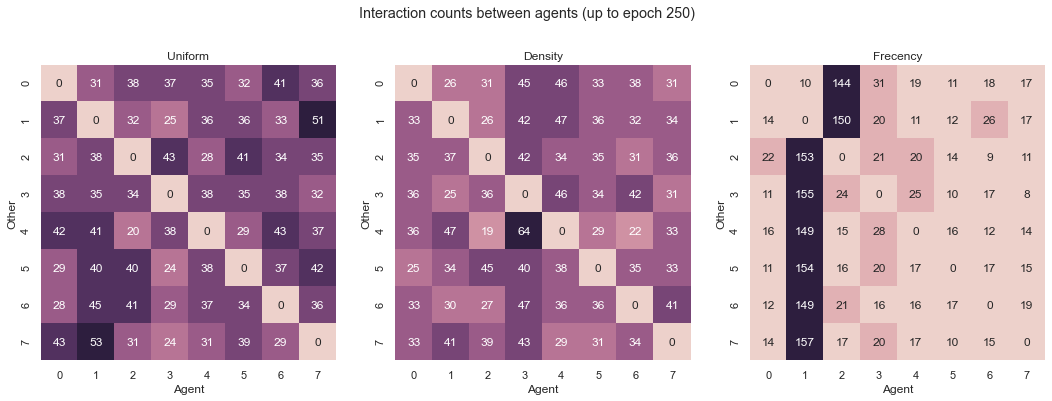

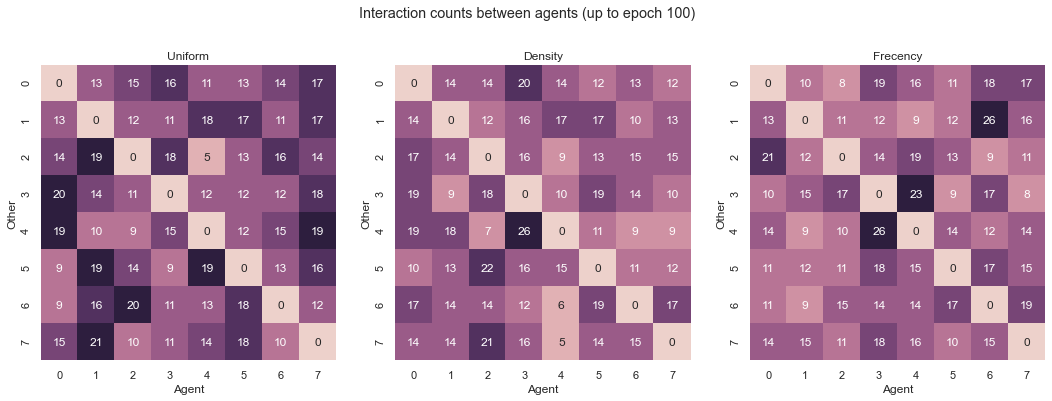

In [45]:
def calculate_cm(interactions, parameters, max_epoch=None):
    n_agents = parameters.n_agents
    n_neighbours = parameters.n_neighbours

    cm = np.zeros((n_agents, n_agents), dtype='int')

    for x in range(n_agents):
        q = f"agent_id == {x}" + ("" if max_epoch is None else f" and epoch < {max_epoch}")
        neighbours = np.array(interactions.query(q)["neighbours"].to_list())[:, n_neighbours]
        unique, counts = np.unique(neighbours.flatten(), return_counts=True)
        
        for i, y in enumerate(unique):
            cm[x, y] = counts[i]

    return cm

# ------------- UP TO EPOCH 250

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle(f"Interaction counts between agents (up to epoch {250})")

cms = [calculate_cm(data["interactions"], data['parameters']) for data in simulations]

for i, (ax, cm) in enumerate(zip(axs.flatten(), cms)):
    sns.heatmap(cm, ax=ax, annot=True, vmin=np.min(cm), vmax=np.max(cm), fmt='0', 
                cmap=sns.cubehelix_palette(8), square=True, cbar=False)
    ax.set_title(sim_labels[i])
    ax.set_ylabel("Other")
    ax.set_xlabel("Agent")


# ------------- UP TO EPOCH 100

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle(f"Interaction counts between agents (up to epoch {100})")

cms = [calculate_cm(data["interactions"], data['parameters'], 100) for data in simulations]

for i, (ax, cm) in enumerate(zip(axs.flatten(), cms)):
    sns.heatmap(cm, ax=ax, annot=True, vmin=np.min(cm), vmax=np.max(cm), fmt='0', 
                cmap=sns.cubehelix_palette(8), square=True, cbar=False)
    ax.set_title(sim_labels[i])
    ax.set_ylabel("Other")
    ax.set_xlabel("Agent")

plt.show()

250